# Рекомендация тарифов

В нашем распоряжении проект о построении и выборе модели, которая выберет подходящий тариф.
У нас имеются данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали в предыдущем проекте.

В данном проекте построим модель с максимально большим значением *accuracy*. Также будем пытаться довести долю правильных ответов по крайней мере до 0.75. А далее проверим *accuracy* на тестовой выборке.

## Откройте и изучите файл

In [1]:
import pandas as pd #Импортируем библиотеку pandas.

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
display(df) #Просмотрим краткое содержание файла

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


В нашем распоряжении, 5 колонок:  
**сalls** — количество звонков,  
**minutes** — суммарная длительность звонков в минутах,  
**messages** — количество sms-сообщений,  
**mb_used** — израсходованный интернет-трафик в Мб,  
**is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0.  
А также 3214 строк информации.

Посмотрим на данные в графическом формате 

<function matplotlib.pyplot.show(close=None, block=None)>

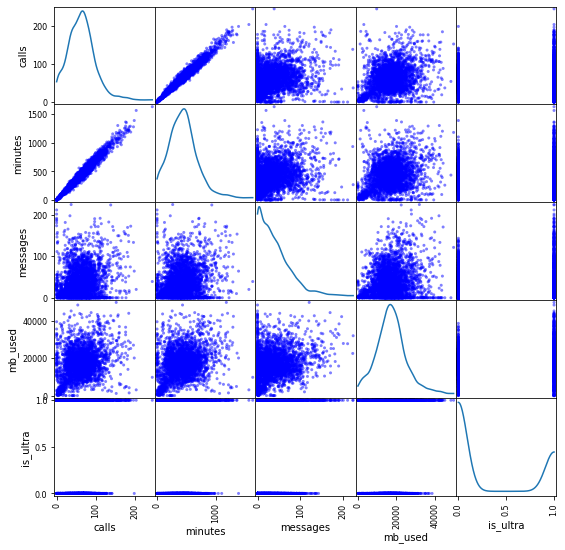

In [5]:
import matplotlib.pyplot as plt # Импортируем библиотеку matplotlib
pd.plotting.scatter_matrix(df, color='blue', diagonal='kde',  figsize=(9, 9))
plt.show

Данные графики показывают взаимосвязь между всеми переменными в наборе данных одновременно. В данных графиках наиболее повышенный интерес предоставляет связка *"Звонки-Минуты"* (**calls-minutes**). Ниже рассмотрим данный график поближе.
Прежде, рассмотрим, общую корреляцию данных в цифровом формате. 

In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Самую высокую корреляцию показывают фреймы звонки и минуты, в этом есть своя логика, если абонент звонит, то непременно потратит, как минимум, одну минуту. Именно поэтому корреляция близка к единице.

In [7]:
print(df['calls'].corr(df['minutes']))

0.9820832355742293


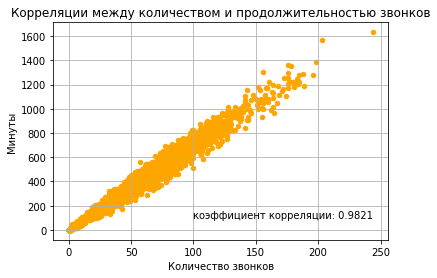

In [8]:
df.plot(x='calls', y='minutes', kind='scatter', color='orange', grid=True) 
plt.text(100, 95, 'коэффициент корреляции: ' + str(round(df['calls'].corr(df['minutes']), 4)))
plt.title("Корреляции между количеством и продолжительностью звонков")
plt.ylabel("Минуты")
plt.xlabel("Количество звонков")
plt.show()

Чем больше абоненты звонят тем больше минут проговаривают. Связь довольно крепка. Коэфициент равен **0,9821**.

## Разбейте данные на выборки

Для начала разделим данные на целевой признак и остальные признаки.

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Наша цель, это подбор подходящего тарифа, поэтому переносим в переменную target, все данные колонки 'is_ultra'. А все остальные данные (признаки) передадим в переменную features.

In [10]:
display(features) #Посмотрим на наши новые переменные.

,calls,minutes,messages,mb_used
0,40.0,311.90,83.0,19915.42
1,85.0,516.75,56.0,22696.96
2,77.0,467.66,86.0,21060.45
3,106.0,745.53,81.0,8437.39
4,66.0,418.74,1.0,14502.75
...,...,...,...,...
3209,122.0,910.98,20.0,35124.90
3210,25.0,190.36,0.0,3275.61
3211,97.0,634.44,70.0,13974.06
3212,64.0,462.32,90.0,31239.78


In [11]:
display(target) #Переменная target, с данными о целевом признаке.

0       0
1       0
2       0
3       1
4       0
       ..
3209    1
3210    0
3211    0
3212    0
3213    1
Name: is_ultra, Length: 3214, dtype: int64

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части на обучающую, валидационную и тестовую выборки.
Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1.

In [12]:
from sklearn.model_selection import train_test_split # импортируем функции деления датасета

In [13]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345) 

In [14]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test,
                                                                            target_test, test_size=0.5, random_state=12345
                                                                           ) 

In [15]:
display(len(features_valid)) 
display(target_valid.shape) #Смотрим на размеры валидационной выборки

643

(643,)

In [16]:
display(features_test.shape)
display(target_test.shape) #Смотрим на размеры тестовой выборки

(643, 4)

(643,)

In [17]:
display(features_train.shape)
display(target_train.shape) #Смотрим на размеры обучающей выборки

(1928, 4)

(1928,)

Данные разбиты в соотношении (1928:643:643), то есть 3:1:1.

In [18]:
1928+643+643

3214

## Исследуйте модели

Модель Решающее дерево. **Decision Tree Classifier**

In [19]:
from sklearn.tree import DecisionTreeClassifier #Импортируем функцию.
from sklearn.metrics import accuracy_score #Для просмотра точности, необходимо импортировать данную функцию. 

In [20]:
for depth in range(1,30,2): # Просмотрим глубину дерева до 30 уровня с шагом в 2 уровня.
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) # присваиваем модели имя
    model_tree.fit(features_train,target_train) # обучаем
    prediction_tree = model_tree.predict(features_valid) # получаем предсказания модели
    
  
    print('max_depth:',depth,end='')
    print(' accuracy:',accuracy_score(prediction_tree,target_valid))

max_depth: 1 accuracy: 0.7542768273716952
max_depth: 3 accuracy: 0.7853810264385692
max_depth: 5 accuracy: 0.7791601866251944
max_depth: 7 accuracy: 0.7822706065318819
max_depth: 9 accuracy: 0.7822706065318819
max_depth: 11 accuracy: 0.7620528771384136
max_depth: 13 accuracy: 0.7558320373250389
max_depth: 15 accuracy: 0.7465007776049767
max_depth: 17 accuracy: 0.7356143079315708
max_depth: 19 accuracy: 0.7278382581648523
max_depth: 21 accuracy: 0.7278382581648523
max_depth: 23 accuracy: 0.7169517884914464
max_depth: 25 accuracy: 0.713841368584759
max_depth: 27 accuracy: 0.713841368584759
max_depth: 29 accuracy: 0.713841368584759


Наблюдаем наилучший результат на уровне 3. *0.7853810264385692*

Модель Случайный лес. **Random Forest**

In [21]:
from sklearn.ensemble import RandomForestClassifier #Импортируем модель.

In [22]:
best_model = None
best_result = 0
for est in range(1, 40):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) # обучаем модель с заданным количеством деревьев
    model_forest.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    result = model_forest.score(features_valid, target_valid) # считаем качество модели на валидационной выборке
    if result > best_result:
        best_model = model_forest # сохраняем наилучшую модель
        best_result = result #  сохраняем наилучшее значение метрики accuracy на валидационных данных

print("n_estimators:", est, "depth:", depth, "Accuracy наилучшей модели на валидационной выборке:", best_result)

n_estimators: 39 depth: 29 Accuracy наилучшей модели на валидационной выборке: 0.7947122861586314


Изучили модель случайный лес с 40 деревьями . Лучший результат показался на 39 дереве, на уровне глубины 29.  

Модель Логическая Регрессия. **Logistic Regression**

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
accuracy = accuracy_score(target_valid, predictions)
print('accuracy:', accuracy)

accuracy: 0.7107309486780715


Модель логической регрессии показывает результат хуже остальных моделей - 0.7107309486780715.

## Выводы
Просмотрев 3 модели получаем следующие результаты.  
Модель ***Решающее дерево*** - Лучший результат точности на глубине 3: 0.785381026438569.  
Модель ***Случайный лес*** - Accuracy наилучшей модели на валидационной выборке: 0.7947122861586314  
Модель ***Логическая Регрессия*** - Точность 0.7107309486780715.  
Таким образом самая лучшая модель с лучшим результатом - это **Случайный лес**.

## Проверьте модель на тестовой выборке

Проверим нашу модель на лучшей тестовой выборке. В нашей ситуации это **Случайный Лес**. В прошлый раз мы добились уровня точности *0.7947122861586314*.

Дадим нашей модели имя - **Forest** (Лес). А имя компьютерной переменной будет *model_forest*.

Для улучшения результатов точности, поменяем некоторые гиперпараметры:

In [25]:
model_forest = RandomForestClassifier(max_depth=9, n_estimators=10, random_state=12345)
model_forest.fit(features_train,target_train)
prediction_forest = model_forest.predict(features_test)
print('accuracy:', accuracy_score(prediction_forest, target_test))

accuracy: 0.8133748055987559


После измененения гиперпараметров (максимальная глубина 9, количество оценщиков 10, уровень псевдослучайности 12345) удалось достичь уровня точности 0.8133748055987559.

## (бонус) Проверьте модели на адекватность

Проверим модель на адекватность используя DummyClassifier.

In [26]:
import numpy as np
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(features_train, target_train)
dummy.score(features_train, target_train)

0.6924273858921162

Результат простейшей модели 0.6924273858921162, это говорит о том, что модель Случайный Лес лучше, и её точность выше. То есть использование модели *Случайный Лес* оправдывает себя. Напомню, лучший результат **0.8133748055987559**. При использовании нашей модели будем иметь пропорцию купленных тарифов 0.8 к 0.2.

## Общий вывод
В данном исследовании мы рассмотрели базу данных с поведением клиентов, которые уже перешли на тариф Ультра. Попытались создать лучшую модель для подбора тарифа. Изучили 3 основные модели, обучили на соответсвующих выборках. А затем проверили модели на тестовой выборке. А также проверили модель на адекватность с помощью DummyClassifier.  
В заключении пришли к выводу что лучшая модель для подбора тарифа это RandomForest с результатом 0.8133748055987559, то есть модель ошибается лишь в 19% случаев. Таким образом главное требование проекта достигнуто.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
